In [33]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

import numpy as np
import michael_solotky as model
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Генерация выборки

In [274]:
H = 30
W = 40
h = 10
w = 10
K = 100
sigma = 1000.

In [275]:
def generate_samples(H, W, h, w, K, sigma):
    dh_positions = np.random.randint(0, H - h + 1, size=K)
    dw_positions = np.random.randint(0, W - w + 1, size=K)
    picture = np.full((h, w), 50.)
    background = np.full((H, W), 150.)
    samples = np.repeat(background[..., np.newaxis], K, axis=2)
    for k in range(K):
        samples[dh_positions[k]:dh_positions[k] + h, dw_positions[k]:dw_positions[k] + w, k] = picture
    noise = np.random.normal(loc=0., scale=sigma, size=(H, W, K))
    samples += noise
    return picture, background, samples, noise

In [276]:
picture, background, samples, noise = generate_samples(H, W, h, w, K, sigma)

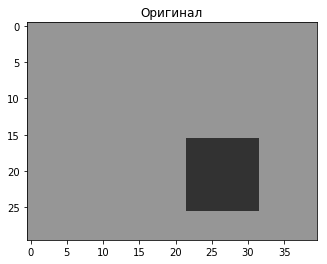

In [267]:
plt.imshow(samples[:, :, 3] - noise[:, :, 3], 'gray', vmin=0, vmax=255)
plt.title('Оригинал')
#plt.savefig('report/clean1.pdf', bbox_inches='tight')

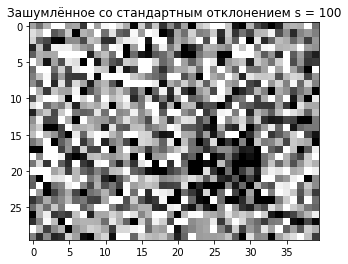

In [268]:
plt.imshow(samples[:, :, 3], 'gray', vmin=0, vmax=255)
plt.title('Зашумлённое со стандартным отклонением s = 100')
#plt.savefig('report/noisy2.pdf', bbox_inches='tight')

## Запуск из разных начальных приближений и сравнение качества

In [277]:
%%time
lb_results = []
for i in range(50):
    F, B, s, A, lower_bound_array = model.run_EM(samples, h, w, tolerance=0.001, max_iter=1000, use_MAP=False)
    lb_results.append(lower_bound_array[-1])

CPU times: user 34min 59s, sys: 15.1 s, total: 35min 14s
Wall time: 1h 40min 59s


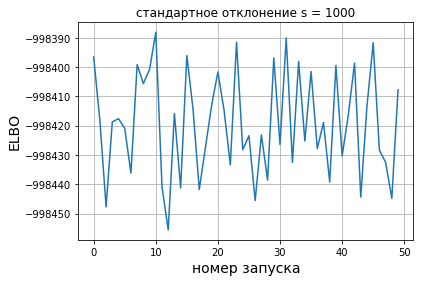

In [278]:
plt.plot(np.arange(50), lb_results)
plt.grid()
plt.title('стандартное отклонение s = 1000')
plt.xlabel('номер запуска', fontsize=14)
plt.ylabel('ELBO', fontsize=14)
plt.savefig('report/llresult2.pdf', bbox_inches='tight')

## Траектории обучения

In [279]:
%%time
lb_results = []
for i in range(10):
    F, B, s, A, lower_bound_array = model.run_EM(samples, h, w, tolerance=0.001, max_iter=1000, use_MAP=False)
    lb_results.append(lower_bound_array)

CPU times: user 5min 47s, sys: 2.07 s, total: 5min 49s
Wall time: 5min 49s


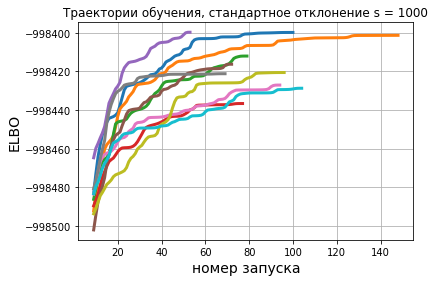

In [293]:
for i in range(10):
    plt.plot(np.arange(lb_results[i].size - 9) + 9, lb_results[i][9:], linewidth=3)
plt.grid()
plt.title('Траектории обучения, стандартное отклонение s = 1000')
plt.xlabel('номер запуска', fontsize=14)
plt.ylabel('ELBO', fontsize=14)
plt.savefig('report/trajectory.pdf', bbox_inches='tight')

## Запуск EM с рестартами

In [169]:
%%time
F, B, s, A, lower_bound = model.run_EM_with_restarts(samples, h, w, tolerance=0.001,
                                                     max_iter=100, use_MAP=False, n_restarts=10)

CPU times: user 2min 39s, sys: 966 ms, total: 2min 40s
Wall time: 2min 40s


In [295]:
params = {
    'K': [1, 10, 100, 1000],
    's': [1, 10, 100, 1000, 10000]
}

In [296]:
for K in params['K']:
    for sigma in params['s']:
        picture, background, samples, noise = generate_samples(H, W, h, w, K, sigma)
        F, B, s, A, lower_bound = model.run_EM_with_restarts(samples, h, w, tolerance=0.001,
                                                             max_iter=100, use_MAP=False,
                                                             n_restarts=10)
        print("(K={0}, sigma={1}): lower_bound={2}".format(K, sigma, lower_bound / K))

(K=1, sigma=1): lower_bound=37248.94147689677
(K=1, sigma=10): lower_bound=37263.32299096457
(K=1, sigma=100): lower_bound=36887.97996644338
(K=1, sigma=1000): lower_bound=34625.45517230184
(K=1, sigma=10000): lower_bound=31822.854882960433
(K=10, sigma=1): lower_bound=-1636.6274705001078
(K=10, sigma=10): lower_bound=-5529.962025580378
(K=10, sigma=100): lower_bound=-7198.180669490264
(K=10, sigma=1000): lower_bound=-9907.131288476054
(K=10, sigma=10000): lower_bound=-12691.474627674985
(K=100, sigma=1): lower_bound=-1699.3660349101096
(K=100, sigma=10): lower_bound=-4464.015533712138
(K=100, sigma=100): lower_bound=-7225.380039831045
(K=100, sigma=1000): lower_bound=-9988.79172668249
(K=100, sigma=10000): lower_bound=-12748.062313378163
(K=1000, sigma=1): lower_bound=-1708.4887907376622
(K=1000, sigma=10): lower_bound=-4469.674844292604
(K=1000, sigma=100): lower_bound=-7234.253647173558


KeyboardInterrupt: 

## Сравнение с hard-EM

In [310]:
%%timeit
K = 10
sigma = 10
picture, background, samples, noise = generate_samples(H, W, h, w, K, sigma)
F, B, s, A, lower_bound = model.run_EM_with_restarts(samples, h, w, tolerance=0.001,
                                                     max_iter=50, use_MAP=False,
                                                     n_restarts=1)

1.01 s ± 379 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [329]:
K = 10
sigma = 10
picture, background, samples, noise = generate_samples(H, W, h, w, K, sigma)
F, B, s, A, lower_bound = model.run_EM_with_restarts(samples, h, w, tolerance=0.001,
                                                     max_iter=50, use_MAP=False,
                                                     n_restarts=1)

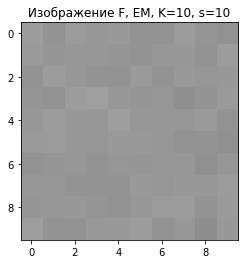

In [330]:
plt.imshow(F, 'gray', vmin=0, vmax=255)
plt.title('Изображение F, EM, K=10, s=10')
plt.savefig('report/EMFK10s10.pdf', bbox_inches='tight')

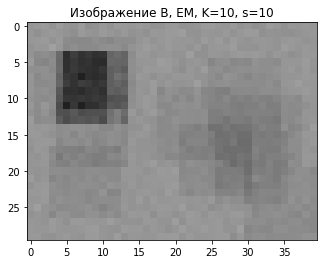

In [331]:
plt.imshow(B, 'gray', vmin=0, vmax=255)
plt.title('Изображение B, EM, K=10, s=10')
plt.savefig('report/EMBK10s10.pdf', bbox_inches='tight')

In [325]:
%%timeit
K = 10
sigma = 10
picture, background, samples, noise = generate_samples(H, W, h, w, K, sigma)
F, B, s, A, lower_bound = model.run_EM_with_restarts(samples, h, w, tolerance=0.001,
                                                     max_iter=100, use_MAP=True,
                                                     n_restarts=1)

214 ms ± 57.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [332]:
K = 10
sigma = 10
picture, background, samples, noise = generate_samples(H, W, h, w, K, sigma)
F, B, s, A, lower_bound = model.run_EM_with_restarts(samples, h, w, tolerance=0.001,
                                                     max_iter=100, use_MAP=True,
                                                     n_restarts=1)

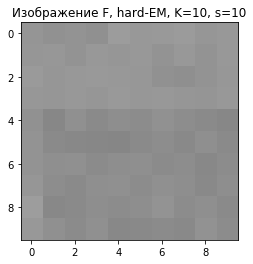

In [333]:
plt.imshow(F, 'gray', vmin=0, vmax=255)
plt.title('Изображение F, hard-EM, K=10, s=10')
plt.savefig('report/EMMAPFK10s10.pdf', bbox_inches='tight')

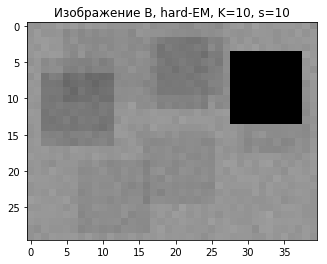

In [334]:
plt.imshow(B, 'gray', vmin=0, vmax=255)
plt.title('Изображение B, hard-EM, K=10, s=10')
plt.savefig('report/EMMAPBK10s10.pdf', bbox_inches='tight')

## Разоблачение преступника

In [4]:
data = np.load('data_vmk18_1000.npy')

In [5]:
data.shape

(107, 200, 1000)

In [6]:
w = 74
h = 102

In [ ]:
%%time
F, B, s, A, lower_bound = model.run_EM_with_restarts(data, h, w, tolerance=0.001,
                                                     max_iter=1, use_MAP=False,
                                                     n_restarts=1)

In [ ]:
F_list = []
B_list = []
lb_list = []
for i in range(5):
    F, B, s, A, lower_bound = model.run_EM_with_restarts(data[:100 * i], h, w, tolerance=0.001,
                                                         max_iter=100, use_MAP=False,
                                                         n_restarts=5)
    F_list.append(F)
    B_list.append(B)
    lb_list.append(lower_bound)

In [38]:
%%time
F, B, s, A, lower_bound = model.run_EM(data[:, :, :250], h, w, tolerance=0.001,
                                       max_iter=1000, use_MAP=False)

1
2


KeyboardInterrupt: 

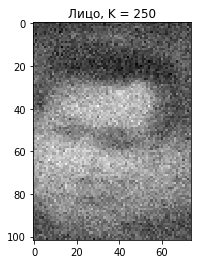

In [28]:
plt.imshow(F, cmap='gray')
plt.title('Лицо, K = 250')
#plt.savefig('report/vilainface250.pdf', bbox_inches='tight')

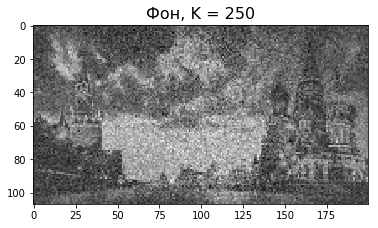

In [31]:
plt.imshow(B, cmap='gray')
plt.title('Фон, K = 250', fontsize=16)
plt.savefig('report/vilainbackground250.pdf', bbox_inches='tight')